# Introduction
To test the validity of our algorithm to model an semi-flexible and extensible bead-spring chain, we first study a straight trimer with a known rigidity and spring constant between bonds. 

Beads 0,1,2 are connected in series with the preferred angle between line segments 0-1 and 1-2 being zero.

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv, erfi
from scipy.integrate import quad
from scipy.signal import savgol_filter, correlate, fftconvolve
from scipy.sparse import csr_matrix, dia_matrix, csc_matrix, coo_matrix
from scipy import fftpack
import torch
from functools import reduce
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'torch device: {device}')

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.pylab as plb

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.helpers as ahlp
import alens_analysis.read_func as arf
from alens_analysis import physical_scales as ps

# Graph style settings
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)
        

torch device: cuda


# Data

In [32]:
data_dir = Path.home() / "projects/DATA/my_alens_data"
data_dir_list = [
    data_dir / "BrownianDimer_dt.0001",
    data_dir / "BrownianDimer_dt.00001",
    data_dir / "BrownianTrimer",
    data_dir / "SemiFlexTrimer",
]
for i in data_dir_list:
    assert i.exists(), f"{i} does not exist"


In [33]:
# Collect raw data using alens_analysis
for i in data_dir_list:
    opts = lambda: None # Create an empty object to store analysis options
    opts.path = i
    opts.analysis = 'collect' # This replicates the -A flag when running `analens -A collect`
    opts.analysis_dir = opts.path / 'analysis' # Specify where to store the analysis files
    opts.analysis_dir.mkdir(exist_ok=True) # Make sure the analysis directory exists
    opts.overwrite = True # Overwrite existing analysis files

    aa.seed_analysis(opts)

raw_BrownianDimer_dt
Made time data set in 5.607534885406494 seconds.
Made sylinder data set in 3.9903581142425537 seconds.
Made protin data set in 4.323357105255127 seconds.
Made raw data file in a total of 13.921748161315918 seconds.
 HDF5 raw created in 15.104117155075073
raw_BrownianDimer_dt
Made time data set in 5.813292026519775 seconds.
Made sylinder data set in 3.8704299926757812 seconds.
Made protin data set in 4.465894937515259 seconds.
Made raw data file in a total of 14.14994215965271 seconds.
 HDF5 raw created in 15.696741819381714
raw_BrownianTrimer
Made time data set in 0.41440629959106445 seconds.
Made sylinder data set in 0.32709693908691406 seconds.
Made protin data set in 0.4865739345550537 seconds.
Made raw data file in a total of 1.2284033298492432 seconds.
 HDF5 raw created in 1.3398799896240234
raw_SemiFlexTrimer
Made time data set in 0.06737804412841797 seconds.
Made sylinder data set in 0.32094383239746094 seconds.
Made protin data set in 0.19606399536132812 se

## Brownian dimer

0.020746646


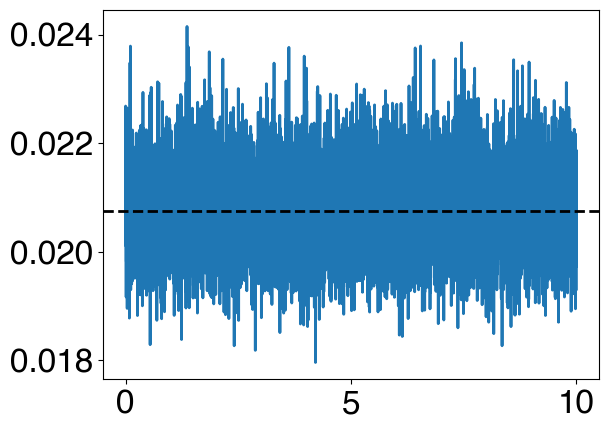

In [23]:
with h5py.File(next(data_dir_list[0].glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][:] # Load in time array, [:] loads data as numpy array
    # Load in sylinder data
    sy_dat = h5_data['raw_data/sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    dist_arr = np.linalg.norm(com_arr[1,:,:] - com_arr[0, :, :], axis=0)
    plt.plot(time_arr, dist_arr)
    plt.axhline(dist_arr.mean(), color='k', linestyle='--')
    print(dist_arr.mean())

0.020746646


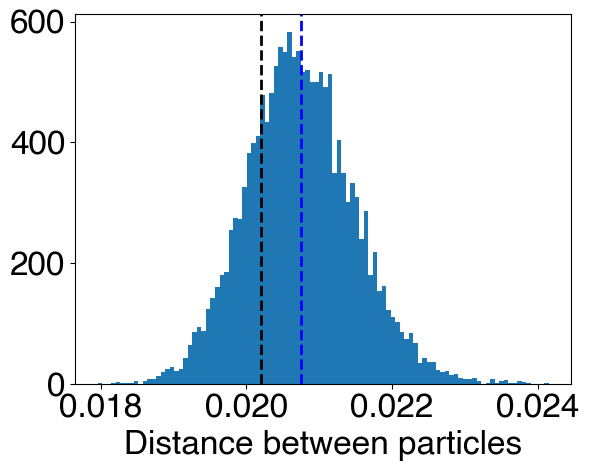

In [77]:
# timestep = 0.0001
# timesnap = 0.001
# Total time = 10
with h5py.File(next(data_dir_list[0].glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][:] 
    # Load in sylinder data
    sy_dat = h5_data['raw_data/sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    dist_arr = np.linalg.norm(com_arr[1,:,:] - com_arr[0, :, :], axis=0)
    _ = plt.hist(dist_arr, bins=100, density=True)
    _ = plt.axvline(dist_arr.mean(), color='blue', linestyle='--')
    _ = plt.axvline(.0202, color='black', linestyle='--')
    _ = plt.xlabel('Distance between particles')
    print(dist_arr.mean())

0.02035404


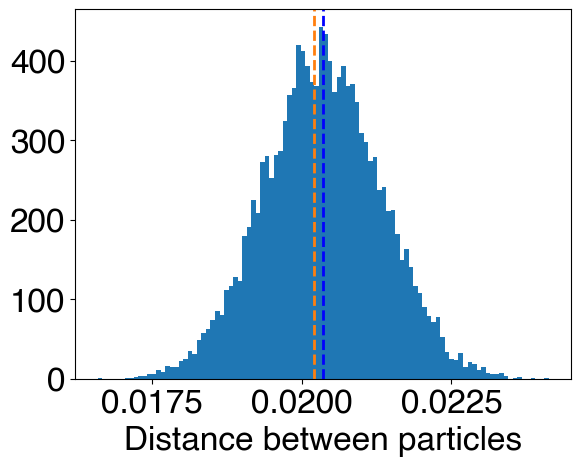

In [27]:
# timestep = 0.0001
# timesnap = 0.001
# Total time = 10
with h5py.File(next(data_dir_list[0].glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][:] 
    # Load in sylinder data
    sy_dat = h5_data['raw_data/sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    dist_arr = np.linalg.norm(com_arr[1,:,:] - com_arr[0, :, :], axis=0)
    _ = plt.hist(dist_arr, bins=100, density=True)
    _ = plt.axvline(dist_arr.mean(), color='blue', linestyle='--')
    _ = plt.axvline(.0202, color='tab:orange', linestyle='--')
    _ = plt.xlabel('Distance between particles')
    print(dist_arr.mean())

## Brownian trimer

0.024172353


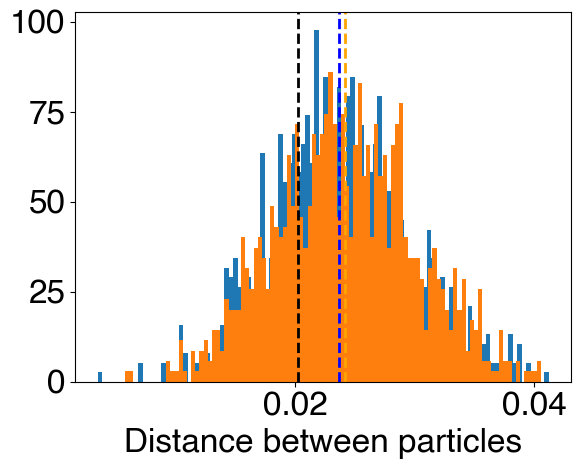

In [26]:
# timestep = 0.0001
# timesnap = 0.001
# Total time = 10
with h5py.File(next(data_dir_list[2].glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][:] 
    # Load in sylinder data
    sy_dat = h5_data['raw_data/sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    dist_arr = np.linalg.norm(com_arr[1,:,:] - com_arr[0, :, :], axis=0)
    _ = plt.hist(dist_arr, bins=100, density=True)
    _ = plt.axvline(dist_arr.mean(), color='blue', linestyle='--')
    dist_arr = np.linalg.norm(com_arr[2,:,:] - com_arr[1, :, :], axis=0)
    _ = plt.hist(dist_arr, bins=100, density=True)
    _ = plt.axvline(dist_arr.mean(), color='orange', linestyle='--')
    _ = plt.axvline(.0202, color='black', linestyle='--')
    _ = plt.xlabel('Distance between particles')
    print(dist_arr.mean())

## Brownian semi-flexible trimer

We would like to test the distribution of angles between line segments 0-1 and 1-2. We would also like to study the distribution of segment lengths of the trimer. We will choose parameters so that the trimers angle distribution has a standard deviation of $\pi/16$ and the segment lengths of 20\% of the average bond length.

The angle distribution is given by the following equation:
$$ P(\theta) = \frac{\sin(\theta)\exp\left(-\frac{\beta\kappa_B\theta^2}{2}\right)}{Z}$$
with the partition function given by
$$Z = \int_0^\pi d\theta \sin(\theta)\exp\left(-\frac{\beta\kappa_B\theta^2}{2}\right)= \frac{1}{2} e^{-\frac{1}{2 \beta  \kappa _B}} \sqrt{\frac{\pi}{2\beta  \kappa _B}} \left(2 \text{erfi}\left(\frac{1}{
   \sqrt{2\beta  \kappa _B}}\right)-\text{erfi}\left(\frac{1-i \pi  \beta  \kappa _B}{ \sqrt{2\beta  \kappa _B}}\right)-\text{erfi}\left(\frac{1+i
   \pi  \beta  \kappa _B}{\sqrt{2 \beta  \kappa _B}}\right)\right)$$
with $\kappa_B$ being the bending rigidity of the chain and $\beta=1/k_BT$. Note: the full probability distribution comes from integrating the Boltzmann factor of the total energy 
$$e^{-\beta U({\bf r}_1,{\bf r}_2)} \quad \text{where} \quad U({\bf r}_1,{\bf r}_2) = \frac{k}{2}(r_1 - r_o)^2 + \frac{k}{2}(r_2- r_o)^2 + \frac{\kappa_B}{2}(\cos^{-1}(\hat{r}_1\cdot\hat{r}_2))^2,$$
over all space, but the radial contribution cancels out with the same term in the partition function when you marginalize radial extension. 
<!-- The average angle is given by 
$$\langle\theta\rangle=\frac{\sqrt{\frac{2}{\pi }} \left(1-\exp\left(-\frac{\pi^2}{2\sigma_\theta^2}\right)\right)}{\sigma_\theta \text{erf}\left(\frac{\pi }{\sqrt{2}\sigma_\theta}\right)}$$  -->
The standard deviation is given by $\sigma_\theta=\sqrt{\frac{1}{\beta\kappa_B}}$. Since the inverse temperature is $\beta = 1/.0041$ pN $\mu\text{m}$ we can choose $\kappa_B = \frac{1}{\beta\sigma_\theta^2} = \frac{.0041}{\left(\frac{\pi}{16}\right)^2}$

In [59]:
kappa = .0041/(np.power(np.pi/16., 2))
kappa

0.10634671435099774

I will leave the spring stiffness at $k=3650$ pN/$\mu\text{m}$ though we should see how changing this affects the results.

### Run parameters
```yaml
viscosity : 1 # pN s/um^2
dt : 0.00001 s 
T_tot : 1 s  
t_snap : 0.001 s 
tribendLinkKappa: [.106, .106, .106] # pN/rad
extendLinkKappa: 3650 # pN/um 
extendLinkGap: .0002 # um .02 diameter
KBT: 0.00411 # controls Brownian motion of MT
```

### Results

0.02035404


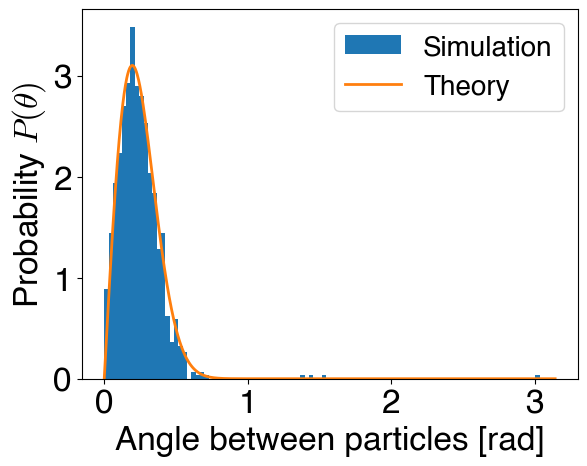

In [61]:
theta_arr = np.linspace(0, np.pi, 1000)
sigma = .00411/kappa
partition_func = .5 * np.exp(-0.5*sigma)*np.sqrt(.5*np.pi*sigma)*( 2* erfi(np.sqrt(sigma*.5))
                                                                   -erfi((1.j*np.pi+sigma)/np.sqrt(sigma*.5))
                                                                   -erfi((-1.j*np.pi+sigma)/np.sqrt(sigma*.5)))
prob_func = np.sin(theta_arr)*np.exp(-np.power(theta_arr,2)/(2.*sigma))/partition_func

# timestep = 0.0001
# timesnap = 0.001
# Total time = 10
with h5py.File(next(data_dir_list[3].glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][:] 
    # Load in sylinder data
    sy_dat = h5_data['raw_data/sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    distij_arr = np.linalg.norm(com_arr[1,:,:] - com_arr[0, :, :], axis=0)
    distjk_arr = np.linalg.norm(com_arr[2,:,:] - com_arr[1, :, :], axis=0)
    dirij_arr = (com_arr[1,:,:] - com_arr[0, :, :]) / distij_arr
    dirjk_arr = (com_arr[2,:,:] - com_arr[1, :, :]) / distjk_arr
    dot_arr = np.einsum('ij,ij->j', dirij_arr, dirjk_arr)
    angle_arr = np.arccos(dot_arr)
    _ = plt.hist(angle_arr, bins=100, density=True, label='Simulation')
    _ = plt.plot(theta_arr, prob_func, label='Theory')
    _ = plt.legend()
    # _ = plt.axvline(dist_arr.mean(), color='blue', linestyle='--')
    # dist_arr = np.linalg.norm(com_arr[2,:,:] - com_arr[1, :, :], axis=0)
    # _ = plt.hist(dist_arr, bins=100, density=True)
    # _ = plt.axvline(dist_arr.mean(), color='orange', linestyle='--')
    # _ = plt.axvline(.0202, color='black', linestyle='--')
    _ = plt.xlabel('Angle between particles [rad]')
    _ = plt.ylabel('Probability $P(\\theta)$')
    print(dist_arr.mean())

/Users/alamson/local/miniconda/envs/alens_analysis/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


0.020358114


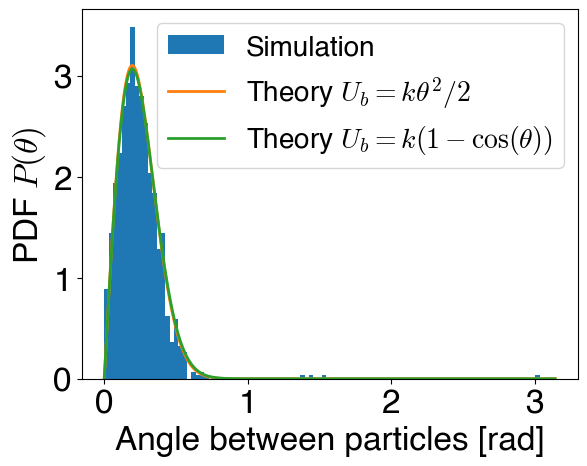

In [68]:
theta_arr = np.linspace(0, np.pi, 1000)
sigma2 = .00411/kappa
sigma = .00411/kappa
partition_func1 = .5 * np.exp(-0.5*sigma)*np.sqrt(.5*np.pi*sigma)*( 2* erfi(np.sqrt(sigma*.5))
                                                                   -erfi((1.j*np.pi+sigma)/np.sqrt(sigma*.5))
                                                                   -erfi((-1.j*np.pi+sigma)/np.sqrt(sigma*.5)))
prob_func1 = np.sin(theta_arr)*np.exp(-np.power(theta_arr,2)/(2.*sigma))/partition_func1
partition_func2 = (1-np.exp(-2/(sigma2)))*(sigma2)
prob_func2 = np.sin(theta_arr)*np.exp((np.cos(theta_arr)-1.)/(sigma2))/partition_func2

# timestep = 0.0001
# timesnap = 0.001
# Total time = 10
with h5py.File(next(data_dir_list[3].glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][:] 
    # Load in sylinder data
    sy_dat = h5_data['raw_data/sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    distij_arr = np.linalg.norm(com_arr[1,:,:] - com_arr[0, :, :], axis=0)
    distjk_arr = np.linalg.norm(com_arr[2,:,:] - com_arr[1, :, :], axis=0)
    dirij_arr = (com_arr[1,:,:] - com_arr[0, :, :]) / distij_arr
    dirjk_arr = (com_arr[2,:,:] - com_arr[1, :, :]) / distjk_arr
    dot_arr = np.einsum('ij,ij->j', dirij_arr, dirjk_arr)
    angle_arr = np.arccos(dot_arr)
    _ = plt.hist(angle_arr, bins=100, density=True, label='Simulation')
    _ = plt.plot(theta_arr, prob_func1, label='Theory $U_b = k\\theta^2/2$')
    _ = plt.plot(theta_arr, prob_func2, label='Theory $U_b = k(1-\cos(\\theta))$')
    _ = plt.legend()
    _ = plt.xlabel('Angle between particles [rad]')
    _ = plt.ylabel('PDF $P(\\theta)$')
    print(dist_arr.mean())

We want to make sure the distance between beads is also still agreeing with expected results.

0.020358114


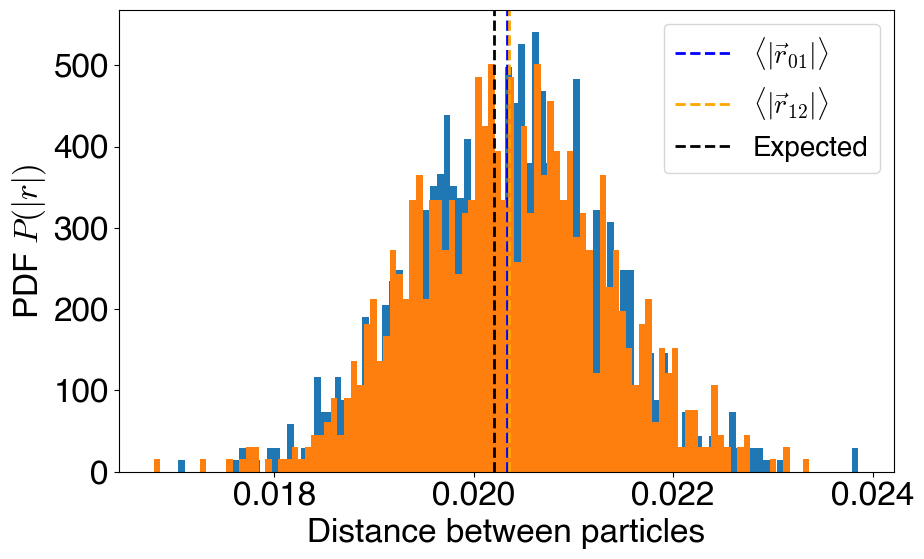

In [76]:
# timestep = 0.0001
# timesnap = 0.001
# Total time = 10
with h5py.File(next(data_dir_list[3].glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][:] 
    # Load in sylinder data
    sy_dat = h5_data['raw_data/sylinders'][...]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
    dist_arr = np.linalg.norm(com_arr[1,:,:] - com_arr[0, :, :], axis=0)
    _ = plt.figure(figsize=(10,6))
    _ = plt.hist(dist_arr, bins=100, density=True)
    _ = plt.axvline(dist_arr.mean(), color='blue', linestyle='--', label='$\langle|\\vec{r}_{01}|\\rangle$')
    dist_arr = np.linalg.norm(com_arr[2,:,:] - com_arr[1, :, :], axis=0)
    _ = plt.hist(dist_arr, bins=100, density=True)
    _ = plt.axvline(dist_arr.mean(), color='orange', linestyle='--', label='$\langle|\\vec{r}_{12}|\\rangle$')
    _ = plt.axvline(.0202, color='black', linestyle='--', label='Expected')
    _ = plt.xlabel('Distance between particles')
    _ = plt.ylabel('PDF $P(|r|)$')
    _ = plt.legend()
    print(dist_arr.mean())

Not bad considering how stiff the connecting bonds are.

# Larger tests and scan of parameters

We should test the two spring stiffnesses together to make sure there is no unexpected growth of errors between them. We will measure these as the standard deviation of the angle distribution and the standard deviation of the distance between beads. For bending rigidity we will us angle deviations of $\sigma_b=\{\pi/2, \pi/16, \pi/64\}$ and for spring stiffness $\kappa = k_bT/\sigma^2$ where $\sigma=\{b, b/10, b/100\}$.

In [86]:
kBT = .00411
kappa_bend = kBT/(np.power(np.array([np.pi/2, np.pi/16.,np.pi/64]), 2))
kappa_bend 
b=.02
kappa_ext = kBT/(np.power(np.array([b*1, b*.1,b*.01]), 2))
kappa_ext

array([1.66572026e-03, 1.06606097e-01, 1.70569755e+00])

array([1.0275e+01, 1.0275e+03, 1.0275e+05])

We will also us 1000 trimers with 1000 time snapshots with $t_{snap}=.001$ for a total time of 1 second different time steps $dt = \{10^{-6}, 10^{-5}, 10^{-4}, 10^{-3}\}$ s. Just to make sure that we achieve relaxation during these times.

In [91]:
gamma = ps.get_drag_coeff(.02, 1)
tau = gamma/kappa_ext 
tau

array([3.66901332e-02, 3.66901332e-04, 3.66901332e-06])

In [4]:
test_dir = Path.home() / "projects/DATA/Testing/SemiFlexTrimer"
h5_list = list(test_dir.glob('simulations/*/analysis/raw*.h5'))
print(h5_list)

[PosixPath('/mnt/home/alamson/projects/DATA/Testing/SemiFlexTrimer/simulations/ks1e+05_kb1.7_dt0.0001/analysis/raw_tmp.h5'), PosixPath('/mnt/home/alamson/projects/DATA/Testing/SemiFlexTrimer/simulations/ks1e+05_kb0.11_dt1e-06/analysis/raw_tmp.h5'), PosixPath('/mnt/home/alamson/projects/DATA/Testing/SemiFlexTrimer/simulations/ks1e+05_kb0.0017_dt0.001/analysis/raw_tmp.h5'), PosixPath('/mnt/home/alamson/projects/DATA/Testing/SemiFlexTrimer/simulations/ks1e+03_kb0.0017_dt0.001/analysis/raw_tmp.h5'), PosixPath('/mnt/home/alamson/projects/DATA/Testing/SemiFlexTrimer/simulations/ks10_kb0.0017_dt1e-05/analysis/raw_tmp.h5'), PosixPath('/mnt/home/alamson/projects/DATA/Testing/SemiFlexTrimer/simulations/ks1e+05_kb0.11_dt0.0001/analysis/raw_tmp.h5'), PosixPath('/mnt/home/alamson/projects/DATA/Testing/SemiFlexTrimer/simulations/ks1e+05_kb1.7_dt1e-05/analysis/raw_tmp.h5'), PosixPath('/mnt/home/alamson/projects/DATA/Testing/SemiFlexTrimer/simulations/ks1e+03_kb0.11_dt0.0001/analysis/raw_tmp.h5'), Pos

In [47]:
theta_arr = np.linspace(0, np.pi, 1000)
def get_theta_potential_theory(theta_arr, kappa):
    sigma2 = .00411/kappa
    partition_func = .5 * np.exp(-0.5*sigma2)*np.sqrt(.5*np.pi*sigma2)*( 2* erfi(np.sqrt(sigma2*.5))
                                                                   -erfi((1.j*np.pi+sigma2)/np.sqrt(sigma2*.5))
                                                                   -erfi((-1.j*np.pi+sigma2)/np.sqrt(sigma2*.5)))
    prob_func = np.sin(theta_arr)*np.exp(-np.power(theta_arr,2)/(2.*sigma2))/partition_func
    return prob_func

def get_cosine_potential_theory(theta_arr,kappa):
    sigma2 = .00411/kappa
    partition_func = (1-np.exp(-2/(sigma2)))*(sigma2)
    prob_func = np.sin(theta_arr)*np.exp((np.cos(theta_arr)-1.)/(sigma2))/partition_func
    return prob_func

data_dict = {}
for h5d in h5_list:
    with h5py.File(h5d, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        kappa_extend = run_params['extendLinkKappa']
        kappa_bend = run_params['tribendLinkKappa']
        dt = run_params['dt']
        # See if dt value is already in data_dict. If not add it otherwise append to existing list
        if kappa_extend not in data_dict:
            data_dict[kappa_extend] = {}
        if kappa_bend not in data_dict[kappa_extend]:
            data_dict[kappa_extend][kappa_bend] = {}
        data_dict[kappa_extend][kappa_bend][dt]= h5d



In [48]:
pprint(data_dict)

{10.275: {0.00166572026: {1e-06: PosixPath('/mnt/home/alamson/projects/DATA/Testing/SemiFlexTrimer/simulations/ks10_kb0.0017_dt1e-06/analysis/raw_tmp.h5'),
                          1e-05: PosixPath('/mnt/home/alamson/projects/DATA/Testing/SemiFlexTrimer/simulations/ks10_kb0.0017_dt1e-05/analysis/raw_tmp.h5'),
                          0.0001: PosixPath('/mnt/home/alamson/projects/DATA/Testing/SemiFlexTrimer/simulations/ks10_kb0.0017_dt0.0001/analysis/raw_tmp.h5'),
                          0.001: PosixPath('/mnt/home/alamson/projects/DATA/Testing/SemiFlexTrimer/simulations/ks10_kb0.0017_dt0.001/analysis/raw_tmp.h5')},
          0.106606097: {1e-06: PosixPath('/mnt/home/alamson/projects/DATA/Testing/SemiFlexTrimer/simulations/ks10_kb0.11_dt1e-06/analysis/raw_tmp.h5'),
                        1e-05: PosixPath('/mnt/home/alamson/projects/DATA/Testing/SemiFlexTrimer/simulations/ks10_kb0.11_dt1e-05/analysis/raw_tmp.h5'),
                        0.0001: PosixPath('/mnt/home/alamson/projects

dt = 0.0001
dt = 1e-06
dt = 1e-05
dt = 0.001


/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


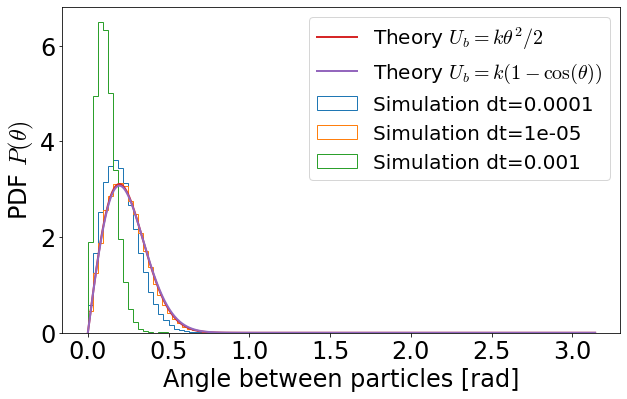

In [59]:
h5_file_dt_arr= data_dict[1027.5][0.106606097]
_ = plt.figure(figsize=(10,6))
for k, v in h5_file_dt_arr.items():
    with h5py.File(v, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        kappa_bend = run_params['tribendLinkKappa']
        kappa_extend = run_params['extendLinkKappa']
        dt = run_params['dt']
        print(f'dt = {dt}')
        time_arr = h5_data['time'][:] 
        # Load in sylinder data
        try:
            sy_dat = h5_data['raw_data/sylinders'][...]
        except:
            continue
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        angle_arr = []
        for i in range(0, com_arr.shape[0], 3):
            distij_arr = np.linalg.norm(com_arr[i+1,:,:] - com_arr[i, :, :], axis=0)
            distjk_arr = np.linalg.norm(com_arr[i+2,:,:] - com_arr[i+1, :, :], axis=0)
            dirij_arr = (com_arr[i+1,:,:] - com_arr[i, :, :]) / distij_arr
            dirjk_arr = (com_arr[i+2,:,:] - com_arr[i+1, :, :]) / distjk_arr
            dot_arr = np.einsum('ij,ij->j', dirij_arr, dirjk_arr)
            angle_arr += (np.arccos(dot_arr).tolist())
        # distij_arr = np.linalg.norm(com_arr[1,:,:] - com_arr[0, :, :], axis=0)
        # distjk_arr = np.linalg.norm(com_arr[2,:,:] - com_arr[1, :, :], axis=0)
        # dirij_arr = (com_arr[1,:,:] - com_arr[0, :, :]) / distij_arr
        # dirjk_arr = (com_arr[2,:,:] - com_arr[1, :, :]) / distjk_arr
        # dot_arr += np.einsum('ij,ij->j', dirij_arr, dirjk_arr)
        # angle_arr = np.arccos(dot_arr).tolist()
        _ = plt.hist(angle_arr, bins=100, density=True, label=f'Simulation dt={dt}', histtype='step')

_ = plt.plot(theta_arr, get_theta_potential_theory(theta_arr, kappa_bend), label='Theory $U_b = k\\theta^2/2$')
_ = plt.plot(theta_arr, get_cosine_potential_theory(theta_arr, kappa_bend), label='Theory $U_b = k(1-\cos(\\theta))$')
# _ = plt.xlim(0, 1)
_ = plt.legend()
_ = plt.xlabel('Angle between particles [rad]')
_ = plt.ylabel('PDF $P(\\theta)$')
        # print(dist_arr.mean())

dt = 0.001
dt = 0.0001
dt = 1e-05
dt = 1e-06


/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


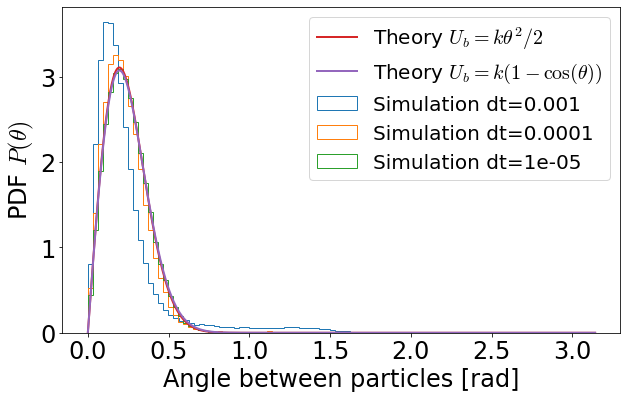

In [67]:
h5_file_dt_arr= data_dict[10.275][0.106606097]
_ = plt.figure(figsize=(10,6))
for k, v in h5_file_dt_arr.items():
    with h5py.File(v, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        kappa_bend = run_params['tribendLinkKappa']
        kappa_extend = run_params['extendLinkKappa']
        dt = run_params['dt']
        print(f'dt = {dt}')
        time_arr = h5_data['time'][:] 
        # Load in sylinder data
        try:
            sy_dat = h5_data['raw_data/sylinders'][...]
        except:
            continue
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        angle_arr = []
        for i in range(0, com_arr.shape[0], 3):
            distij_arr = np.linalg.norm(com_arr[i+1,:,:] - com_arr[i, :, :], axis=0)
            distjk_arr = np.linalg.norm(com_arr[i+2,:,:] - com_arr[i+1, :, :], axis=0)
            dirij_arr = (com_arr[i+1,:,:] - com_arr[i, :, :]) / distij_arr
            dirjk_arr = (com_arr[i+2,:,:] - com_arr[i+1, :, :]) / distjk_arr
            dot_arr = np.einsum('ij,ij->j', dirij_arr, dirjk_arr)
            angle_arr += (np.arccos(dot_arr).tolist())
        # distij_arr = np.linalg.norm(com_arr[1,:,:] - com_arr[0, :, :], axis=0)
        # distjk_arr = np.linalg.norm(com_arr[2,:,:] - com_arr[1, :, :], axis=0)
        # dirij_arr = (com_arr[1,:,:] - com_arr[0, :, :]) / distij_arr
        # dirjk_arr = (com_arr[2,:,:] - com_arr[1, :, :]) / distjk_arr
        # dot_arr += np.einsum('ij,ij->j', dirij_arr, dirjk_arr)
        # angle_arr = np.arccos(dot_arr).tolist()
        _ = plt.hist(angle_arr, bins=100, density=True, label=f'Simulation dt={dt}', histtype='step')

_ = plt.plot(theta_arr, get_theta_potential_theory(theta_arr, kappa_bend), label='Theory $U_b = k\\theta^2/2$')
_ = plt.plot(theta_arr, get_cosine_potential_theory(theta_arr, kappa_bend), label='Theory $U_b = k(1-\cos(\\theta))$')
# _ = plt.xlim(0, 1)
_ = plt.legend()
_ = plt.xlabel('Angle between particles [rad]')
_ = plt.ylabel('PDF $P(\\theta)$')
        # print(dist_arr.mean())

dt = 0.001
dt = 0.0001
dt = 1e-06
dt = 1e-05


/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


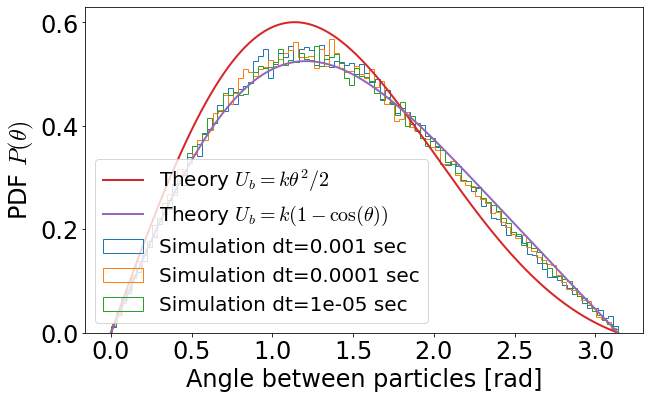

In [66]:
h5_file_dt_arr= data_dict[1027.5][0.00166572026]
_ = plt.figure(figsize=(10,6))
for k, v in h5_file_dt_arr.items():
    with h5py.File(v, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        kappa_bend = run_params['tribendLinkKappa']
        kappa_extend = run_params['extendLinkKappa']
        dt = run_params['dt']
        print(f'dt = {dt}')
        time_arr = h5_data['time'][:] 
        # Load in sylinder data
        try:
            sy_dat = h5_data['raw_data/sylinders'][...]
        except:
            continue
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        angle_arr = []
        for i in range(0, com_arr.shape[0], 3):
            distij_arr = np.linalg.norm(com_arr[i+1,:,:] - com_arr[i, :, :], axis=0)
            distjk_arr = np.linalg.norm(com_arr[i+2,:,:] - com_arr[i+1, :, :], axis=0)
            dirij_arr = (com_arr[i+1,:,:] - com_arr[i, :, :]) / distij_arr
            dirjk_arr = (com_arr[i+2,:,:] - com_arr[i+1, :, :]) / distjk_arr
            dot_arr = np.einsum('ij,ij->j', dirij_arr, dirjk_arr)
            angle_arr += (np.arccos(dot_arr).tolist())
        # distij_arr = np.linalg.norm(com_arr[1,:,:] - com_arr[0, :, :], axis=0)
        # distjk_arr = np.linalg.norm(com_arr[2,:,:] - com_arr[1, :, :], axis=0)
        # dirij_arr = (com_arr[1,:,:] - com_arr[0, :, :]) / distij_arr
        # dirjk_arr = (com_arr[2,:,:] - com_arr[1, :, :]) / distjk_arr
        # dot_arr += np.einsum('ij,ij->j', dirij_arr, dirjk_arr)
        # angle_arr = np.arccos(dot_arr).tolist()
        _ = plt.hist(angle_arr, bins=100, density=True, label=f'Simulation dt={dt} sec', histtype='step')

_ = plt.plot(theta_arr, get_theta_potential_theory(theta_arr, kappa_bend), label='Theory $U_b = k\\theta^2/2$')
_ = plt.plot(theta_arr, get_cosine_potential_theory(theta_arr, kappa_bend), label='Theory $U_b = k(1-\cos(\\theta))$')
# _ = plt.xlim(0, 1)
_ = plt.legend()
_ = plt.xlabel('Angle between particles [rad]')
_ = plt.ylabel('PDF $P(\\theta)$')
        # print(dist_arr.mean())

dt = 0.001
dt = 1e-06
dt = 0.0001


/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


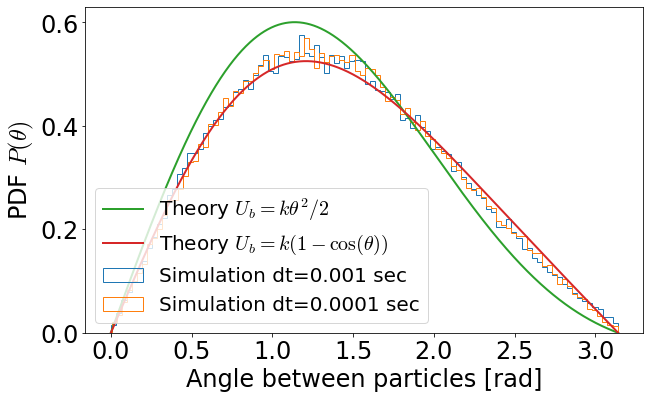

In [69]:
h5_file_dt_arr= data_dict[102750.0][0.00166572026]
_ = plt.figure(figsize=(10,6))
for k, v in h5_file_dt_arr.items():
    with h5py.File(v, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        kappa_bend = run_params['tribendLinkKappa']
        kappa_extend = run_params['extendLinkKappa']
        dt = run_params['dt']
        print(f'dt = {dt}')
        time_arr = h5_data['time'][:] 
        # Load in sylinder data
        try:
            sy_dat = h5_data['raw_data/sylinders'][...]
        except:
            continue
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        angle_arr = []
        for i in range(0, com_arr.shape[0], 3):
            distij_arr = np.linalg.norm(com_arr[i+1,:,:] - com_arr[i, :, :], axis=0)
            distjk_arr = np.linalg.norm(com_arr[i+2,:,:] - com_arr[i+1, :, :], axis=0)
            dirij_arr = (com_arr[i+1,:,:] - com_arr[i, :, :]) / distij_arr
            dirjk_arr = (com_arr[i+2,:,:] - com_arr[i+1, :, :]) / distjk_arr
            dot_arr = np.einsum('ij,ij->j', dirij_arr, dirjk_arr)
            angle_arr += (np.arccos(dot_arr).tolist())
        # distij_arr = np.linalg.norm(com_arr[1,:,:] - com_arr[0, :, :], axis=0)
        # distjk_arr = np.linalg.norm(com_arr[2,:,:] - com_arr[1, :, :], axis=0)
        # dirij_arr = (com_arr[1,:,:] - com_arr[0, :, :]) / distij_arr
        # dirjk_arr = (com_arr[2,:,:] - com_arr[1, :, :]) / distjk_arr
        # dot_arr += np.einsum('ij,ij->j', dirij_arr, dirjk_arr)
        # angle_arr = np.arccos(dot_arr).tolist()
        _ = plt.hist(angle_arr, bins=100, density=True, label=f'Simulation dt={dt} sec', histtype='step')

_ = plt.plot(theta_arr, get_theta_potential_theory(theta_arr, kappa_bend), label='Theory $U_b = k\\theta^2/2$')
_ = plt.plot(theta_arr, get_cosine_potential_theory(theta_arr, kappa_bend), label='Theory $U_b = k(1-\cos(\\theta))$')
# _ = plt.xlim(0, 1)
_ = plt.legend()
_ = plt.xlabel('Angle between particles [rad]')
_ = plt.ylabel('PDF $P(\\theta)$')
        # print(dist_arr.mean())

dt = 0.0001


/tmp/ipykernel_845959/1591924919.py:24: RuntimeWarning: invalid value encountered in arccos
  angle_arr += (np.arccos(dot_arr).tolist())


dt = 1e-06
dt = 0.001


/tmp/ipykernel_845959/1591924919.py:24: RuntimeWarning: invalid value encountered in arccos
  angle_arr += (np.arccos(dot_arr).tolist())


dt = 1e-05


/tmp/ipykernel_845959/1591924919.py:24: RuntimeWarning: invalid value encountered in arccos
  angle_arr += (np.arccos(dot_arr).tolist())
/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


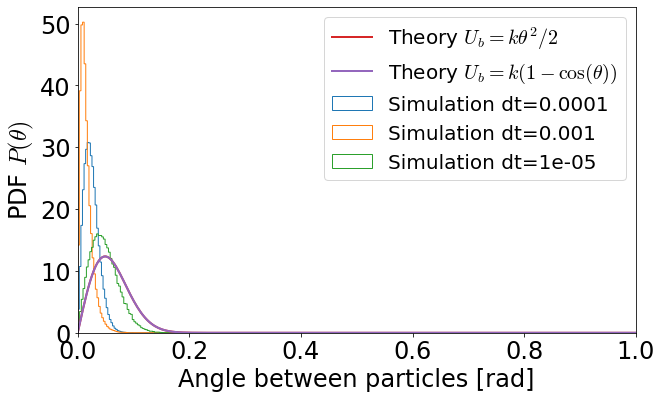

In [63]:
h5_file_dt_arr= data_dict[1027.5][1.70569755]
_ = plt.figure(figsize=(10,6))
for k, v in h5_file_dt_arr.items():
    with h5py.File(v, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        kappa_bend = run_params['tribendLinkKappa']
        kappa_extend = run_params['extendLinkKappa']
        dt = run_params['dt']
        print(f'dt = {dt}')
        time_arr = h5_data['time'][:] 
        # Load in sylinder data
        try:
            sy_dat = h5_data['raw_data/sylinders'][...]
        except:
            continue
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        angle_arr = []
        for i in range(0, com_arr.shape[0], 3):
            distij_arr = np.linalg.norm(com_arr[i+1,:,:] - com_arr[i, :, :], axis=0)
            distjk_arr = np.linalg.norm(com_arr[i+2,:,:] - com_arr[i+1, :, :], axis=0)
            dirij_arr = (com_arr[i+1,:,:] - com_arr[i, :, :]) / distij_arr
            dirjk_arr = (com_arr[i+2,:,:] - com_arr[i+1, :, :]) / distjk_arr
            dot_arr = np.einsum('ij,ij->j', dirij_arr, dirjk_arr)
            angle_arr += (np.arccos(dot_arr).tolist())
        # distij_arr = np.linalg.norm(com_arr[1,:,:] - com_arr[0, :, :], axis=0)
        # distjk_arr = np.linalg.norm(com_arr[2,:,:] - com_arr[1, :, :], axis=0)
        # dirij_arr = (com_arr[1,:,:] - com_arr[0, :, :]) / distij_arr
        # dirjk_arr = (com_arr[2,:,:] - com_arr[1, :, :]) / distjk_arr
        # dot_arr += np.einsum('ij,ij->j', dirij_arr, dirjk_arr)
        # angle_arr = np.arccos(dot_arr).tolist()
        _ = plt.hist(angle_arr, bins=1000, density=True, label=f'Simulation dt={dt}', histtype='step')

_ = plt.plot(theta_arr, get_theta_potential_theory(theta_arr, kappa_bend), label='Theory $U_b = k\\theta^2/2$')
_ = plt.plot(theta_arr, get_cosine_potential_theory(theta_arr, kappa_bend), label='Theory $U_b = k(1-\cos(\\theta))$')
_ = plt.xlim(0, 1)
_ = plt.legend()
_ = plt.xlabel('Angle between particles [rad]')
_ = plt.ylabel('PDF $P(\\theta)$')
        # print(dist_arr.mean())

dt = 1e-06
dt = 0.001


/mnt/home/alamson/local/envs/alens/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


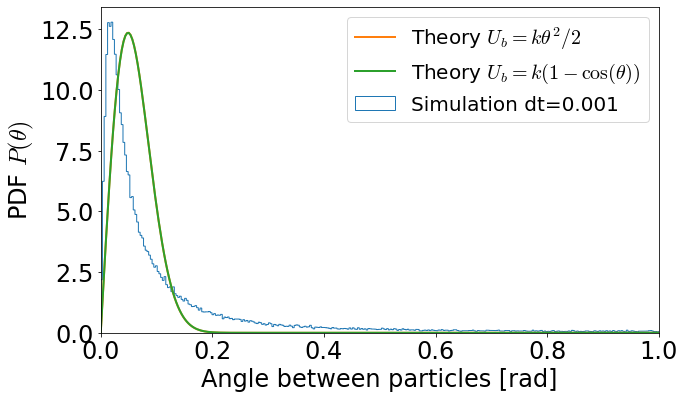

In [68]:
h5_file_dt_arr= data_dict[10.275][1.70569755]
_ = plt.figure(figsize=(10,6))
for k, v in h5_file_dt_arr.items():
    with h5py.File(v, 'r') as h5_data:
        run_params = yaml.safe_load(h5_data.attrs['RunConfig'])
        kappa_bend = run_params['tribendLinkKappa']
        kappa_extend = run_params['extendLinkKappa']
        dt = run_params['dt']
        print(f'dt = {dt}')
        time_arr = h5_data['time'][:] 
        # Load in sylinder data
        try:
            sy_dat = h5_data['raw_data/sylinders'][...]
        except:
            continue
        com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
        angle_arr = []
        for i in range(0, com_arr.shape[0], 3):
            distij_arr = np.linalg.norm(com_arr[i+1,:,:] - com_arr[i, :, :], axis=0)
            distjk_arr = np.linalg.norm(com_arr[i+2,:,:] - com_arr[i+1, :, :], axis=0)
            dirij_arr = (com_arr[i+1,:,:] - com_arr[i, :, :]) / distij_arr
            dirjk_arr = (com_arr[i+2,:,:] - com_arr[i+1, :, :]) / distjk_arr
            dot_arr = np.einsum('ij,ij->j', dirij_arr, dirjk_arr)
            angle_arr += (np.arccos(dot_arr).tolist())
        # distij_arr = np.linalg.norm(com_arr[1,:,:] - com_arr[0, :, :], axis=0)
        # distjk_arr = np.linalg.norm(com_arr[2,:,:] - com_arr[1, :, :], axis=0)
        # dirij_arr = (com_arr[1,:,:] - com_arr[0, :, :]) / distij_arr
        # dirjk_arr = (com_arr[2,:,:] - com_arr[1, :, :]) / distjk_arr
        # dot_arr += np.einsum('ij,ij->j', dirij_arr, dirjk_arr)
        # angle_arr = np.arccos(dot_arr).tolist()
        _ = plt.hist(angle_arr, bins=1000, density=True, label=f'Simulation dt={dt}', histtype='step')

_ = plt.plot(theta_arr, get_theta_potential_theory(theta_arr, kappa_bend), label='Theory $U_b = k\\theta^2/2$')
_ = plt.plot(theta_arr, get_cosine_potential_theory(theta_arr, kappa_bend), label='Theory $U_b = k(1-\cos(\\theta))$')
_ = plt.xlim(0, 1)
_ = plt.legend()
_ = plt.xlabel('Angle between particles [rad]')
_ = plt.ylabel('PDF $P(\\theta)$')
        # print(dist_arr.mean())

# Functions